# EP1 - Mandelbrot set
###### Notebook baseado no dos miniEPs

Preencha o nome dos 5 membros do seu grupo na tabela abaixo:

| Nome | NUSP |
|------|------|
| Caio Andrade | 9797232 |
| Caio Fontes | 10692061 |
| Eduardo Laurentino | 8988212 |
| Thiago Teixeira | 10736987 |
| Washington Meireles | 10737157 |

In [32]:
] up

   Updating registry at `~/.julia/registries/General`


ErrorException: could not load library "libgit2"
/usr/bin/../lib64/libmbedx509.so.0: undefined symbol: mbedtls_mutex_unlock

In [33]:
] st

Status `~/.julia/environments/v1.4/Project.toml`
  [336ed68f] CSV v0.6.1
  [a93c6f00] DataFrames v0.20.2
  [31c24e10] Distributions v0.23.2
  [7073ff75] IJulia v1.21.1
  [1a8c2f83] Query v0.12.2
  [f3b207a7] StatsPlots v0.14.3


## Tarefa 3 - Apresentação dos resultados

### Verificando se os programas estão funcionais:

In [114]:
;make 

gcc -o mandelbrot_omp -std=c11 -lm -fopenmp mandelbrot_omp.c


In [105]:
; ./mandelbrot_seq -2.5 1.5 -2.0 2.0 0

0.000006


In [108]:
; ./mandelbrot_pth -2.5 1.5 -2.0 2.0 1 1

0.000711


In [115]:
;./mandelbrot_omp -2.5 1.5 -2.0 2.0 1 1

0.000030


In [39]:
using DataFrames, Query, StatsPlots, Statistics

function measure_mandelbrot(size, f, typ; thread = 0)
    if f==0 par = `-2.5 1.5 -2.0 2.0` #Full Picture
    elseif f==1 par = `-0.8 -0.7 0.05 0.15` #Seahorse Valley
    elseif f==2 par = `0.175 0.375 -0.1 0.1` #Elephant Valley
    elseif f==3 par = `-0.188 -0.012 0.554 0.754` #Triple Spiral Valley
    end                
    if thread == 0 
        results = parse.(Float64,
            chomp(read(`./$typ $par $size`, String)))
    else
        results = parse.(Float64,
            chomp(read(`./$typ $par $size $thread`, String)))
    end
        
    return DataFrame(size = size,
        f = f,
        threads = thread,
        duration = results[1])
end

measure_mandelbrot (generic function with 1 method)

A função `run_experiments` recebe os mesmos parâmetros `size`, `f`, `method` e `threads`, e um parâmetro adicional `repetitions`, com o número de repetições de cada experimento com um dado número de `threads`. A função devolve um `DataFrame` com todos os experimentos.

In [40]:
function run_experiments(size, f, method, repetitions; threads = [])
    run(`make $method`)
    
    results = DataFrame(size = Int[],
        f = Int[],
        threads = Int[],
        duration = Float64[])  
    
    if threads == []
        for r in 1:repetitions
            for s in size
                append!(results,
                    measure_mandelbrot(s, f, method))    
            end
        end
    else
        for t in threads
            for s in size
                for r in 1:repetitions
                    append!(results,
                        measure_mandelbrot(s, f, method, thread = t))
                    end
                end
            end
        end
    return results
end

run_experiments (generic function with 1 method)

A função `parse_results` recebe um `DataFrame` de resultados, produzido pela função `run_experiments`. A função devolve um `DataFrame` com a média e o intervalo de confiança da média a 95% das estimativas e dos tempos de execução, agrupados por número de threads.

In [41]:
function parse_results(results)
    parsed_results = results |>
                    @groupby({_.threads,_.size}) |>
                    @map({threads = key(_).threads,
                          size = _.size[1],
                          mean_duration = mean(_.duration),
                          ci_duration = 1.96 * std(_.duration)}) |>
                    DataFrame
    
    return parsed_results
end

parse_results (generic function with 1 method)

## Realizando os experimentos:

### DataFrames:

Parametros a serem utilizados(usamos os mesmos do script `run_measurements.sh`):

In [43]:
size = [2 ^ i for i in 4:13] #resolucao
thread = [2 ^ i for i in 0:5]
repetitions = 15;

#### Sequencial:

In [44]:
fileName = "mandelbrot_seq"

"mandelbrot_seq"

In [45]:
#Full picture
results = run_experiments(size, 0, fileName, repetitions)
seq_full = parse_results(results)

make: 'mandelbrot_seq' is up to date.


,threads,size,mean_duration,ci_duration
,Int64,Int64,Float64,Float64
1,0,16,5.6e-5,9.05285e-6
2,0,32,0.0002025,3.22491e-5
3,0,64,0.0007418,5.60498e-6
4,0,128,0.0029536,0.000123759
5,0,256,0.0114541,3.5358e-5
6,0,512,0.0454288,8.30006e-5
7,0,1024,0.18347,0.00890781
8,0,2048,0.738125,0.0546299
9,0,4096,2.91595,0.105369


In [46]:
#Seahorse valley
results = run_experiments(size, 1, fileName , repetitions)
seq_seahorse = parse_results(results)

make: 'mandelbrot_seq' is up to date.


,threads,size,mean_duration,ci_duration
,Int64,Int64,Float64,Float64
1,0,16,0.0003228,2.92442e-5
2,0,32,0.0012646,5.27398e-5
3,0,64,0.0051023,0.000117509
4,0,128,0.020183,0.00166279
5,0,256,0.0795571,0.000680505
6,0,512,0.319836,0.0151178
7,0,1024,1.27922,0.0677639
8,0,2048,5.07981,0.037043
9,0,4096,20.2846,0.0222578


In [47]:
#Elephant valley
results = run_experiments(size, 2, fileName, repetitions)
seq_elephant = parse_results(results)

make: 'mandelbrot_seq' is up to date.


,threads,size,mean_duration,ci_duration
,Int64,Int64,Float64,Float64
1,0,16,0.0003136,2.51885e-5
2,0,32,0.0012105,6.60626e-5
3,0,64,0.004811,0.000111044
4,0,128,0.0190153,0.000753571
5,0,256,0.0751926,0.000425466
6,0,512,0.300058,0.00107709
7,0,1024,1.19923,0.00395801
8,0,2048,4.79566,0.0149535
9,0,4096,19.1887,0.184678


In [48]:
#Triple spiral
results = run_experiments(size, 3, fileName, repetitions)
seq_tripleSpiral = parse_results(results)

make: 'mandelbrot_seq' is up to date.


,threads,size,mean_duration,ci_duration
,Int64,Int64,Float64,Float64
1,0,16,0.0003627,1.13931e-5
2,0,32,0.0014456,6.35059e-5
3,0,64,0.0058111,0.000296101
4,0,128,0.022827,0.00114868
5,0,256,0.0905581,0.000635128
6,0,512,0.361428,0.0014605
7,0,1024,1.44384,0.00198878
8,0,2048,5.78284,0.0298312
9,0,4096,23.1094,0.0484658


#### PThreads:

In [63]:
fileName = "mandelbrot_pth"

"mandelbrot_pth"

In [64]:
#Full picture
results = run_experiments(size, 0, fileName, repetitions, threads=thread)
pth_full = parse_results(results)

make: 'mandelbrot_pth' is up to date.


,threads,size,mean_duration,ci_duration
,Int64,Int64,Float64,Float64
1,1,16,0.0003114,8.61816e-5
2,1,32,0.0004548,0.000101171
3,1,64,0.0011554,0.000389415
4,1,128,0.0036543,0.000410993
5,1,256,0.0117315,0.00087025
6,1,512,0.0466621,0.00275963
7,1,1024,0.178891,0.00327704
8,1,2048,0.710842,0.00169553
9,1,4096,2.84195,0.00454897


In [65]:
#Seahorse valley
results = run_experiments(size, 1, fileName, repetitions, threads=thread)
pth_seahorse = parse_results(results)

make: 'mandelbrot_pth' is up to date.


,threads,size,mean_duration,ci_duration
,Int64,Int64,Float64,Float64
1,1,16,0.0006057,0.000149629
2,1,32,0.0015164,0.000173664
3,1,64,0.0054291,0.000461779
4,1,128,0.0199806,8.41163e-5
5,1,256,0.0789755,6.2003e-5
6,1,512,0.315121,0.00134078
7,1,1024,1.25797,0.00229108
8,1,2048,5.03762,0.0261172
9,1,4096,20.1212,0.00930737


In [66]:
#Elephant valley
results = run_experiments(size, 2, fileName, repetitions, threads=thread)
pth_elephant = parse_results(results)

make: 'mandelbrot_pth' is up to date.


,threads,size,mean_duration,ci_duration
,Int64,Int64,Float64,Float64
1,1,16,0.0005617,0.000143897
2,1,32,0.0014322,6.47282e-5
3,1,64,0.005054,0.00038594
4,1,128,0.0190474,0.000438982
5,1,256,0.0747919,0.000322182
6,1,512,0.297755,0.00115141
7,1,1024,1.18904,0.0017178
8,1,2048,4.75297,0.00567731
9,1,4096,18.9996,0.0103493


In [67]:
#Triple spiral
results = run_experiments(size, 3, fileName, repetitions, threads=thread)
pth_tripleSpiral = parse_results(results)

make: 'mandelbrot_pth' is up to date.


,threads,size,mean_duration,ci_duration
,Int64,Int64,Float64,Float64
1,1,16,0.0005551,2.55628e-5
2,1,32,0.0018794,0.000674058
3,1,64,0.0060527,0.000462175
4,1,128,0.0228469,0.000452017
5,1,256,0.0901165,0.00129533
6,1,512,0.358583,0.00103231
7,1,1024,1.43251,0.00157079
8,1,2048,5.72774,0.0038398
9,1,4096,22.913,0.0049492


#### OpenMP:

In [117]:
fileName = "mandelbrot_omp"

"mandelbrot_omp"

In [118]:
#Full picture
results = run_experiments(size, 0, fileName, repetitions, threads=thread)
omp_full = parse_results(results)

make: 'mandelbrot_omp' is up to date.


,threads,size,mean_duration,ci_duration
,Int64,Int64,Float64,Float64
1,1,16,9.3e-5,3.7837e-5
2,1,32,0.0002696,8.10829e-5
3,1,64,0.0009214,0.00010973
4,1,128,0.0034415,0.000402936
5,1,256,0.0124406,0.000569705
6,1,512,0.0494292,0.00160788
7,1,1024,0.201296,0.0134307
8,1,2048,0.766819,0.00289666
9,1,4096,3.05816,0.00787521


In [119]:
#Seahores Valley
results = run_experiments(size, 1, fileName, repetitions, threads=thread)
omp_seahorse = parse_results(results)

make: 'mandelbrot_omp' is up to date.


,threads,size,mean_duration,ci_duration
,Int64,Int64,Float64,Float64
1,1,16,0.0003696,4.84543e-5
2,1,32,0.0013157,3.88396e-5
3,1,64,0.0052654,0.000385952
4,1,128,0.0202824,0.000314592
5,1,256,0.0806001,0.000945416
6,1,512,0.320312,0.000462275
7,1,1024,1.27829,0.00134318
8,1,2048,5.11059,0.00593211
9,1,4096,20.4307,0.0147013


In [120]:
#Elephant Valley
results = run_experiments(size, 2, fileName, repetitions, threads=thread)
omp_elephant = parse_results(results)

make: 'mandelbrot_omp' is up to date.


,threads,size,mean_duration,ci_duration
,Int64,Int64,Float64,Float64
1,1,16,0.0003389,1.82103e-5
2,1,32,0.001323,0.000159287
3,1,64,0.0049848,0.000409007
4,1,128,0.0191649,0.000215179
5,1,256,0.0761834,0.000816225
6,1,512,0.303065,0.00196455
7,1,1024,1.20884,0.00249248
8,1,2048,4.82796,0.0048442
9,1,4096,19.3026,0.0126658


In [121]:
#Triple spiral
results = run_experiments(size, 3, fileName, repetitions, threads=thread)
omp_tripleSpiral = parse_results(results)

make: 'mandelbrot_omp' is up to date.


,threads,size,mean_duration,ci_duration
,Int64,Int64,Float64,Float64
1,1,16,0.0004187,4.64653e-5
2,1,32,0.0014873,1.97313e-5
3,1,64,0.0059734,0.000459371
4,1,128,0.0229475,0.000252539
5,1,256,0.0913082,0.000478305
6,1,512,0.367429,0.0133693
7,1,1024,1.4761,0.0804898
8,1,2048,5.81183,0.005814
9,1,4096,23.2412,0.0223732


#### Exportando em .csv:

In [14]:
using CSV
function save_csv_results(parsed_results, name)
    CSV.write(string(name, ".csv"), parsed_results)
end

save_csv_results (generic function with 1 method)

In [123]:
#Sequencial
save_csv_results(seq_full, "seq_full")
save_csv_results(seq_seahorse, "seq_seahorse")
save_csv_results(seq_elephant, "seq_elephant")
save_csv_results(seq_tripleSpiral, "seq_tripleSpiral")

"seq_tripleSpiral.csv"

In [124]:
#Pthreads
save_csv_results(pth_full, "pth_full")
save_csv_results(pth_seahorse, "pth_seahorse")
save_csv_results(pth_elephant, "pth_elephant")
save_csv_results(pth_tripleSpiral, "pth_tripleSpiral")

"pth_tripleSpiral.csv"

In [125]:
#OpenMP
save_csv_results(omp_full, "omp_full")
save_csv_results(omp_seahorse, "omp_seahorse")
save_csv_results(omp_elephant, "omp_elephant")
save_csv_results(omp_tripleSpiral, "omp_tripleSpiral")

"omp_tripleSpiral.csv"

#### Importando .csv:

In [15]:
function read_csv_results(filename)
    return CSV.read(filename)
end

read_csv_results (generic function with 1 method)

In [16]:
#Sequencial
seq_full = read_csv_results("seq_full.csv")
seq_seahorse = read_csv_results("seq_seahorse.csv")
seq_elephant = read_csv_results("seq_elephant.csv")
seq_tripleSpiral = read_csv_results("seq_tripleSpiral.csv")

,threads,size,mean_duration,ci_duration
,Int64,Int64,Float64,Float64
1,0,16,0.0003627,1.13931e-5
2,0,32,0.0014456,6.35059e-5
3,0,64,0.0058111,0.000296101
4,0,128,0.022827,0.00114868
5,0,256,0.0905581,0.000635128
6,0,512,0.361428,0.0014605
7,0,1024,1.44384,0.00198878
8,0,2048,5.78284,0.0298312
9,0,4096,23.1094,0.0484658


In [17]:
#Pthreads
pth_full = read_csv_results("pth_full.csv")
pth_seahorse = read_csv_results("pth_seahorse.csv")
pth_elephant = read_csv_results("pth_elephant.csv")
pth_tripleSpiral = read_csv_results("pth_tripleSpiral.csv")

,threads,size,mean_duration,ci_duration
,Int64,Int64,Float64,Float64
1,1,16,0.0005551,2.55628e-5
2,1,32,0.0018794,0.000674058
3,1,64,0.0060527,0.000462175
4,1,128,0.0228469,0.000452017
5,1,256,0.0901165,0.00129533
6,1,512,0.358583,0.00103231
7,1,1024,1.43251,0.00157079
8,1,2048,5.72774,0.0038398
9,1,4096,22.913,0.0049492


In [18]:
#OpenMP
omp_full = read_csv_results("omp_full.csv")
omp_seahorse = read_csv_results("omp_seahorse.csv")
omp_elephant = read_csv_results("omp_elephant.csv")
omp_tripleSpiral = read_csv_results("omp_tripleSpiral.csv")

,threads,size,mean_duration,ci_duration
,Int64,Int64,Float64,Float64
1,1,16,0.0004187,4.64653e-5
2,1,32,0.0014873,1.97313e-5
3,1,64,0.0059734,0.000459371
4,1,128,0.0229475,0.000252539
5,1,256,0.0913082,0.000478305
6,1,512,0.367429,0.0133693
7,1,1024,1.4761,0.0804898
8,1,2048,5.81183,0.005814
9,1,4096,23.2412,0.0223732


## Gráficos:

Função para gerar os gráficos:

In [101]:
using StatsPlots
function plot_results(x, y1, series_label1, yerror1,
                        y2, series_label2, yerror2,
                        y3, series_label3, yerror3,
                        y4, series_label4, yerror4,
                        y5, series_label5, yerror5,
                        y6, series_label6, yerror6)    
    p = plot(x,        
            y1,
            yerror = yerror1,
            alpha = 0.9,
            labels = series_label1,
            xlabel = "size",
            color = "red",
            lw = 1,
            legend = :topleft)
    
    if y2 != []
            plot!(x,        
            y2,
            yerror = yerror2,
            alpha = 0.9,
            labels = series_label2,
            color = "blue",
            lw = 1,
            legend = :topleft)
    end
    if y3 != []
            plot!(x,        
            y3,
            yerror = yerror3,
            alpha = 0.9,
            labels = series_label3,
            color = "green",
            lw = 1,
            legend = :topleft)
    end
    if y4 != []
            plot!(x,        
            y4,
            yerror = yerror4,
            alpha = 0.9,
            labels = series_label4,
            color = "black",
            lw = 1,
            legend = :topleft)
    end
    if y5 != []
            plot!(x,        
            y5,
            yerror = yerror5,
            alpha = 0.9,
            labels = series_label5,
            color = "purple",
            lw = 1,
            legend = :topleft)
    end
    if y6 != []
            plot!(x,        
            y6,
            yerror = yerror6,
            alpha = 0.9,
            labels = series_label6,
            color = "orange",
            lw = 1,
            legend = :topleft)
    end
    return p
end


plot_results (generic function with 1 method)

### Full picture:
#### Sequencial:

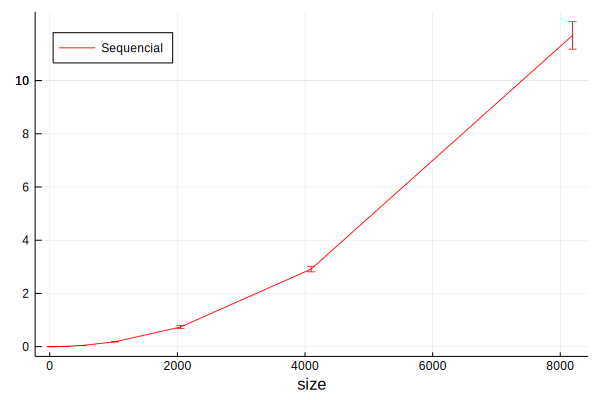

In [102]:
plot_results(seq_full.size, seq_full.mean_duration, "Sequencial", seq_full.ci_duration,
                [], [], [], [], [],
                [], [], [], [], [],
                [], [], [], [], [])

#### Pthreads:

In [103]:
pth_1 = filter(row -> row[:threads] == 1, pth_full)
pth_2 = filter(row -> row[:threads] == 2, pth_full)
pth_4 = filter(row -> row[:threads] == 4, pth_full)
pth_8 = filter(row -> row[:threads] == 8, pth_full)
pth_16 = filter(row -> row[:threads] == 16, pth_full)
pth_32 = filter(row -> row[:threads] == 32, pth_full)

,threads,size,mean_duration,ci_duration
,Int64,Int64,Float64,Float64
1,32,16,0.0007625,5.6793e-5
2,32,32,0.0007628,5.35558e-5
3,32,64,0.0008907,0.000138593
4,32,128,0.0018876,0.000397392
5,32,256,0.0053535,0.000922719
6,32,512,0.0198725,0.00250465
7,32,1024,0.0770299,0.0117247
8,32,2048,0.302769,0.0245286
9,32,4096,1.23207,0.0399808


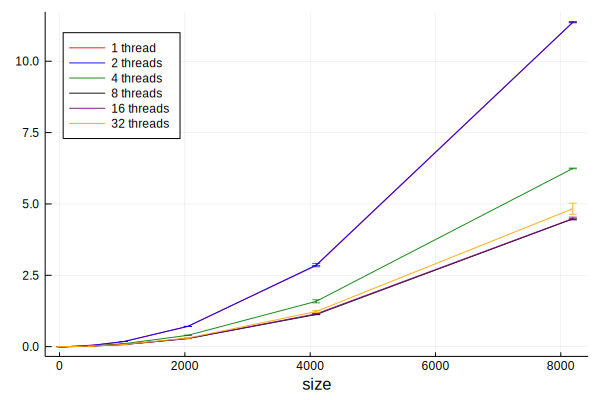

In [104]:
plot_results(pth_1.size, pth_1.mean_duration, "1 thread", pth_1.ci_duration,
            pth_2.mean_duration, "2 threads", pth_2.ci_duration,
            pth_4.mean_duration, "4 threads", pth_4.ci_duration,
            pth_8.mean_duration, "8 threads", pth_8.ci_duration,
            pth_16.mean_duration, "16 threads", pth_16.ci_duration,
            pth_32.mean_duration, "32 threads", pth_32.ci_duration)


#### OpenMP:

In [105]:
omp_1 = filter(row -> row[:threads] == 1, omp_full)
omp_2 = filter(row -> row[:threads] == 2, omp_full)
omp_4 = filter(row -> row[:threads] == 4, omp_full)
omp_8 = filter(row -> row[:threads] == 8, omp_full)
omp_16 = filter(row -> row[:threads] == 16, omp_full)
omp_32 = filter(row -> row[:threads] == 32, omp_full)

,threads,size,mean_duration,ci_duration
,Int64,Int64,Float64,Float64
1,32,16,0.0006678,3.26117e-5
2,32,32,0.0007639,4.87288e-5
3,32,64,0.0009328,4.13803e-5
4,32,128,0.0015994,4.38289e-5
5,32,256,0.0042466,0.000182075
6,32,512,0.0148932,0.000498827
7,32,1024,0.0577154,0.00555457
8,32,2048,0.228107,0.00543908
9,32,4096,0.913169,0.0165756


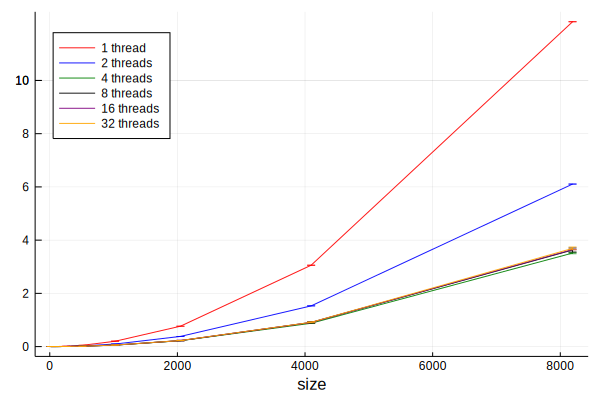

In [106]:
plot_results(omp_1.size, omp_1.mean_duration, "1 thread", omp_1.ci_duration,
            omp_2.mean_duration, "2 threads", omp_2.ci_duration,
            omp_4.mean_duration, "4 threads", omp_4.ci_duration,
            omp_8.mean_duration, "8 threads", omp_8.ci_duration,
            omp_16.mean_duration, "16 threads", omp_16.ci_duration,
            omp_32.mean_duration, "32 threads", omp_32.ci_duration)

### Seahorse Valley:
#### Sequencial:

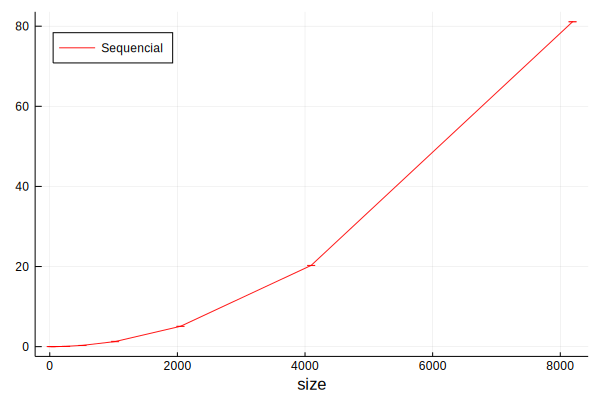

In [107]:
plot_results(seq_seahorse.size, seq_seahorse.mean_duration, "Sequencial", seq_seahorse.ci_duration,
                [], [], [], [], [],
                [], [], [], [], [],
                [], [], [], [], [])

#### Pthreads:

In [108]:
pth_1 = filter(row -> row[:threads] == 1, pth_seahorse)
pth_2 = filter(row -> row[:threads] == 2, pth_seahorse)
pth_4 = filter(row -> row[:threads] == 4, pth_seahorse)
pth_8 = filter(row -> row[:threads] == 8, pth_seahorse)
pth_16 = filter(row -> row[:threads] == 16, pth_seahorse)
pth_32 = filter(row -> row[:threads] == 32, pth_seahorse)

,threads,size,mean_duration,ci_duration
,Int64,Int64,Float64,Float64
1,32,16,0.0008227,3.43737e-5
2,32,32,0.0010128,9.55825e-5
3,32,64,0.0023241,0.000197355
4,32,128,0.0073973,0.000263147
5,32,256,0.0274522,0.00175164
6,32,512,0.105452,0.000914943
7,32,1024,0.417151,0.00543975
8,32,2048,1.66383,0.00956852
9,32,4096,6.62668,0.0191489


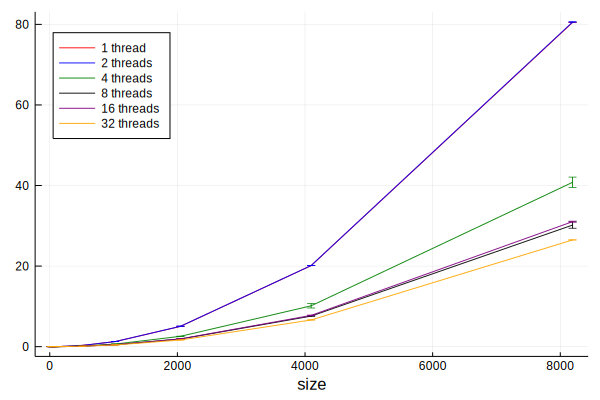

In [109]:
plot_results(pth_1.size, pth_1.mean_duration, "1 thread", pth_1.ci_duration,
            pth_2.mean_duration, "2 threads", pth_2.ci_duration,
            pth_4.mean_duration, "4 threads", pth_4.ci_duration,
            pth_8.mean_duration, "8 threads", pth_8.ci_duration,
            pth_16.mean_duration, "16 threads", pth_16.ci_duration,
            pth_32.mean_duration, "32 threads", pth_32.ci_duration)

#### OpenMP:

In [110]:
omp_1 = filter(row -> row[:threads] == 1, omp_seahorse)
omp_2 = filter(row -> row[:threads] == 2, omp_seahorse)
omp_4 = filter(row -> row[:threads] == 4, omp_seahorse)
omp_8 = filter(row -> row[:threads] == 8, omp_seahorse)
omp_16 = filter(row -> row[:threads] == 16, omp_seahorse)
omp_32 = filter(row -> row[:threads] == 32, omp_seahorse)

,threads,size,mean_duration,ci_duration
,Int64,Int64,Float64,Float64
1,32,16,0.0007906,0.000160768
2,32,32,0.0010874,0.000114302
3,32,64,0.0022038,0.000309146
4,32,128,0.0065223,0.000205494
5,32,256,0.024051,0.000396922
6,32,512,0.0973369,0.00799182
7,32,1024,0.402475,0.0773438
8,32,2048,1.74156,0.386455
9,32,4096,6.23513,0.0228569


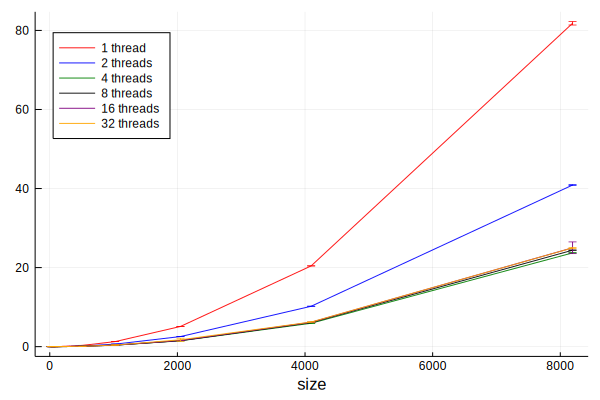

In [111]:
plot_results(omp_1.size, omp_1.mean_duration, "1 thread", omp_1.ci_duration,
            omp_2.mean_duration, "2 threads", omp_2.ci_duration,
            omp_4.mean_duration, "4 threads", omp_4.ci_duration,
            omp_8.mean_duration, "8 threads", omp_8.ci_duration,
            omp_16.mean_duration, "16 threads", omp_16.ci_duration,
            omp_32.mean_duration, "32 threads", omp_32.ci_duration)

### Elephant Valley:
#### Sequencial:

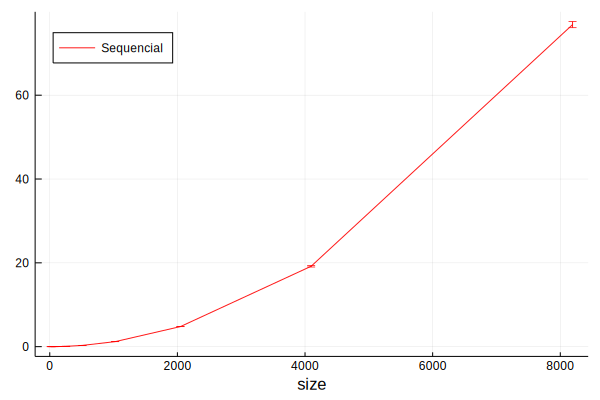

In [112]:
plot_results(seq_elephant.size, seq_elephant.mean_duration, "Sequencial", seq_elephant.ci_duration,
                [], [], [], [], [],
                [], [], [], [], [],
                [], [], [], [], [])

#### Pthreads:

In [113]:
pth_1 = filter(row -> row[:threads] == 1, pth_elephant)
pth_2 = filter(row -> row[:threads] == 2, pth_elephant)
pth_4 = filter(row -> row[:threads] == 4, pth_elephant)
pth_8 = filter(row -> row[:threads] == 8, pth_elephant)
pth_16 = filter(row -> row[:threads] == 16, pth_elephant)
pth_32 = filter(row -> row[:threads] == 32, pth_elephant)

,threads,size,mean_duration,ci_duration
,Int64,Int64,Float64,Float64
1,32,16,0.0008101,5.39975e-5
2,32,32,0.0009968,0.000111469
3,32,64,0.0023449,0.00024886
4,32,128,0.0069286,0.000253892
5,32,256,0.025894,0.00134568
6,32,512,0.0998317,0.00301303
7,32,1024,0.394773,0.00567691
8,32,2048,1.56986,0.00721167
9,32,4096,6.26311,0.0205601


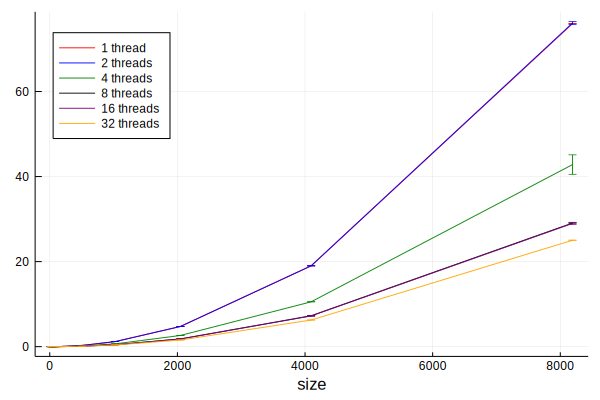

In [114]:
plot_results(pth_1.size, pth_1.mean_duration, "1 thread", pth_1.ci_duration,
            pth_2.mean_duration, "2 threads", pth_2.ci_duration,
            pth_4.mean_duration, "4 threads", pth_4.ci_duration,
            pth_8.mean_duration, "8 threads", pth_8.ci_duration,
            pth_16.mean_duration, "16 threads", pth_16.ci_duration,
            pth_32.mean_duration, "32 threads", pth_32.ci_duration)

#### OpenMP:

In [115]:
omp_1 = filter(row -> row[:threads] == 1, omp_elephant)
omp_2 = filter(row -> row[:threads] == 2, omp_elephant)
omp_4 = filter(row -> row[:threads] == 4, omp_elephant)
omp_8 = filter(row -> row[:threads] == 8, omp_elephant)
omp_16 = filter(row -> row[:threads] == 16, omp_elephant)
omp_32 = filter(row -> row[:threads] == 32, omp_elephant)

,threads,size,mean_duration,ci_duration
,Int64,Int64,Float64,Float64
1,32,16,0.0008014,0.000143222
2,32,32,0.001066,0.000108823
3,32,64,0.0021063,0.000299959
4,32,128,0.0062325,0.000218812
5,32,256,0.0231878,0.00166239
6,32,512,0.0897135,0.00206633
7,32,1024,0.359975,0.00825684
8,32,2048,1.46499,0.0165789
9,32,4096,5.88872,0.01131


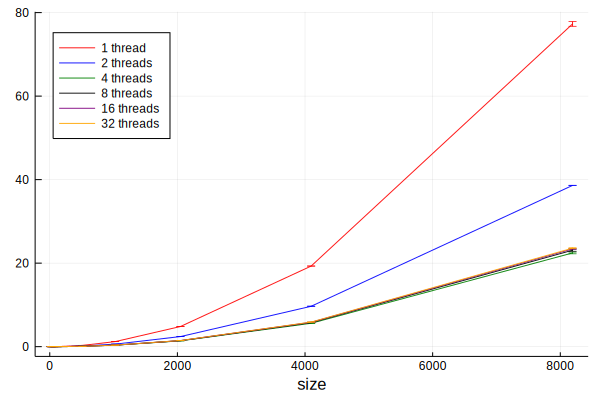

In [116]:
plot_results(omp_1.size, omp_1.mean_duration, "1 thread", omp_1.ci_duration,
            omp_2.mean_duration, "2 threads", omp_2.ci_duration,
            omp_4.mean_duration, "4 threads", omp_4.ci_duration,
            omp_8.mean_duration, "8 threads", omp_8.ci_duration,
            omp_16.mean_duration, "16 threads", omp_16.ci_duration,
            omp_32.mean_duration, "32 threads", omp_32.ci_duration)

### Triple Spiral Valley
#### Sequencial:

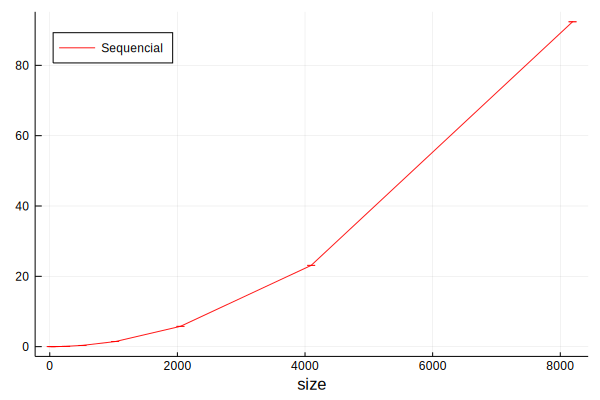

In [117]:
plot_results(seq_tripleSpiral.size, seq_tripleSpiral.mean_duration, "Sequencial", seq_tripleSpiral.ci_duration,
                [], [], [], [], [],
                [], [], [], [], [],
                [], [], [], [], [])

#### Pthreads:

In [118]:
pth_1 = filter(row -> row[:threads] == 1, pth_tripleSpiral)
pth_2 = filter(row -> row[:threads] == 2, pth_tripleSpiral)
pth_4 = filter(row -> row[:threads] == 4, pth_tripleSpiral)
pth_8 = filter(row -> row[:threads] == 8, pth_tripleSpiral)
pth_16 = filter(row -> row[:threads] == 16, pth_tripleSpiral)
pth_32 = filter(row -> row[:threads] == 32, pth_tripleSpiral)

,threads,size,mean_duration,ci_duration
,Int64,Int64,Float64,Float64
1,32,16,0.0008307,4.40218e-5
2,32,32,0.0010605,6.19204e-5
3,32,64,0.0026158,0.000228367
4,32,128,0.008241,0.000414592
5,32,256,0.0308685,0.00137575
6,32,512,0.120244,0.00276654
7,32,1024,0.473346,0.00260174
8,32,2048,1.89716,0.0237083
9,32,4096,7.55163,0.0121124


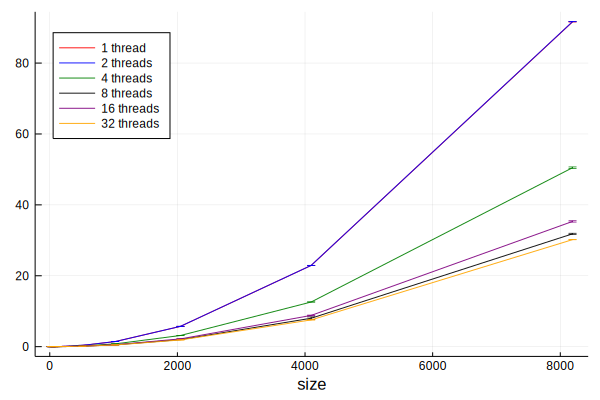

In [119]:
plot_results(pth_1.size, pth_1.mean_duration, "1 thread", pth_1.ci_duration,
            pth_2.mean_duration, "2 threads", pth_2.ci_duration,
            pth_4.mean_duration, "4 threads", pth_4.ci_duration,
            pth_8.mean_duration, "8 threads", pth_8.ci_duration,
            pth_16.mean_duration, "16 threads", pth_16.ci_duration,
            pth_32.mean_duration, "32 threads", pth_32.ci_duration)

#### OpenMP:

In [120]:
omp_1 = filter(row -> row[:threads] == 1, omp_tripleSpiral)
omp_2 = filter(row -> row[:threads] == 2, omp_tripleSpiral)
omp_4 = filter(row -> row[:threads] == 4, omp_tripleSpiral)
omp_8 = filter(row -> row[:threads] == 8, omp_tripleSpiral)
omp_16 = filter(row -> row[:threads] == 16, omp_tripleSpiral)
omp_32 = filter(row -> row[:threads] == 32, omp_tripleSpiral)

,threads,size,mean_duration,ci_duration
,Int64,Int64,Float64,Float64
1,32,16,0.0008034,4.1053e-5
2,32,32,0.0011089,7.18931e-5
3,32,64,0.0024411,0.000325173
4,32,128,0.0073805,0.00015208
5,32,256,0.0273475,0.000853119
6,32,512,0.10917,0.00691513
7,32,1024,0.441167,0.0121982
8,32,2048,1.77401,0.0210278
9,32,4096,7.09882,0.0223834


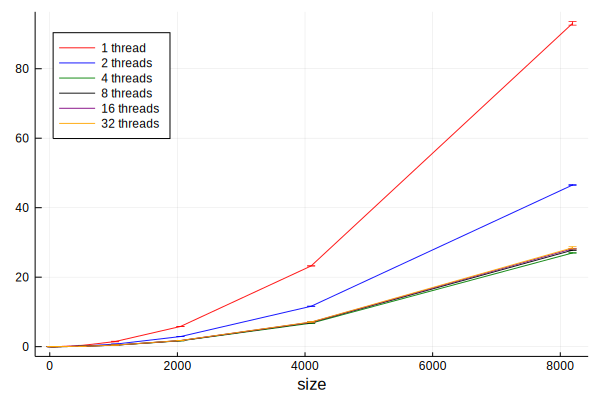

In [121]:
plot_results(omp_1.size, omp_1.mean_duration, "1 thread", omp_1.ci_duration,
            omp_2.mean_duration, "2 threads", omp_2.ci_duration,
            omp_4.mean_duration, "4 threads", omp_4.ci_duration,
            omp_8.mean_duration, "8 threads", omp_8.ci_duration,
            omp_16.mean_duration, "16 threads", omp_16.ci_duration,
            omp_32.mean_duration, "32 threads", omp_32.ci_duration)